# Insulation domains
This notebook documents is used to detect domains in _A. castellanii_.

## Find domains

First, we want to find contact domains on the Hi-C map. We'll do this by first identifying borders, then corners and finding correspondance between borders and corners. Each domain should have 1 corner, with 2 borders (one vertically aligned, the other horizontally.

In [7]:
import os
os.chdir("/home/cmatthey/Repos/Acastellanii_legionella_infection/")

### Border detection

First, we use chromosight to detect domain borders. These borders are all independent: we don't know which pairs of borders form a domain

In [120]:
%%bash
# Chromosight detection with standard borders kernel
mkdir -p tmp/
chromosight detect -u 100 -z 100 -P borders data/output/cool/all_merged.cool tmp/borders

Found 21739 / 22111 detectable bins
Sub matrices extracted
Minimum pattern separation is : 2


pearson set to 0.15 based on config file.
max_dist set to 0 based on config file.
min_dist set to 0 based on config file.
min_separation set to 5000 based on config file.
Matrix already balanced, reusing weights
Preprocessing sub-matrices...
 [====================] 100.0% scaffold_36-scaffold_36
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0
 [=======-------------] 33.3% Kernel: 1, Iteration: 0
 [=============-------] 66.7% Kernel: 2, Iteration: 0
 [====================] 100.0% Kernel: 2, Iteration: 0
2313 patterns detected
Saving patterns in tmp/borders.tsv
Saving patterns in tmp/borders.json
Saving pileup plots in tmp/borders.pdf


### Setup corner kernel

Then we need to generate a new kernel that looks like a domain corner. This can be done with numpy:

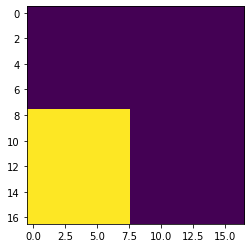

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# Generate a corner kernel
corner_kernel = np.zeros((17, 17))
hw = corner_kernel.shape[0] // 2
corner_kernel[hw:, :hw] = 1
plt.imshow(corner_kernel)

We then use chromosight to generate a template json file that will serve as a configuration for the kernel. We base the configuration on the loops preset, as corners are expected to be found in the same range, but the config can be tweaked a bit. Here we increase the max_dist value to 500kb to allow detecting very large domains. The adjusted configuration can then be saved in place of the template using the json module.

In [130]:
%%bash
# Generate chromosight config
chromosight generate-config corners

In [131]:
# Edit config
import json
cfg = json.load(open('corners.json'))
cfg['name'] = 'corners'
cfg['max_dist'] = 500000
with open('corners.json', 'w') as cfg_handle:
    json.dump(cfg, cfg_handle, indent=4)

The kernel we generated is saved in place of the template kernel associated with the json file.

In [132]:
np.savetxt(cfg['kernels'][0], corner_kernel)

### Detecting corners

We now use the newly generated kernel to detect domain border. Each domain has one corner and two borders, so we will use these corner coordinates to pair borders into domains.

In [140]:
%%bash
# Detect corners
chromosight detect -t12 -p 0.25 -u 80 -z 80 -k corners.json data/output/cool/all_merged.cool tmp/corners

Found 21739 / 22111 detectable bins
Sub matrices extracted
Minimum pattern separation is : 2


max_dist set to 500000 based on config file.
min_dist set to 20000 based on config file.
min_separation set to 5000 based on config file.
Matrix already balanced, reusing weights
Preprocessing sub-matrices...
 [====================] 100.0% scaffold_36-scaffold_36
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0
 [====================] 100.0% Kernel: 0, Iteration: 0
2875 patterns detected
Saving patterns in tmp/corners.tsv
Saving patterns in tmp/corners.json
Saving pileup plots in tmp/corners.pdf


### Assigning domains

We can now load all corners and borders into python and use pandas.`merge_asof` to perform a fuzzy merge. This allows to merge two tables on a numeric column with an error tolerance, which is convenient here, as chromosight detections can sometimes be a few pixels off.

We proceed as follow:
1. Merge borders and corners on their horizontal coordinates to find left-borders.
2. Merge borders and corners on their vertical coordinates to find right-borders.
3. Inner merge on left borders and right borders according to their matched corner to form pairs.

In [141]:
import pandas as pd
# load corners and borders
borders = pd.read_csv('tmp/borders.tsv', sep='\t')
corners = pd.read_csv('tmp/corners.tsv', sep='\t')
corners['corner_id'] = corners.index.values

# Merge corners and borders horizontally -> left borders
domains_l = pd.merge_asof(
    borders.loc[:, ['chrom1', 'start1']].sort_values('start1'),
    corners.loc[:, ['chrom1', 'start1', 'corner_id']].sort_values('start1'),
    by='chrom1',
    on='start1',
    direction='nearest',
    tolerance=8000
).dropna()

# Merge corners and borders vertically -> right borders
domains_r = pd.merge_asof(
    borders.loc[:, ['chrom2', 'start2']].sort_values('start2'),
    corners.loc[:, ['chrom2', 'start2', 'corner_id']].sort_values('start2'),
    by='chrom2',
    on='start2',
    direction='nearest',
    tolerance=8000
).dropna()

# Merge left and right borders on corner id to find domain limits
domains = domains_l.merge(domains_r, on='corner_id', how='inner')
domains['bin1'] = domains.apply(lambda r: clr.extent(f'{r.chrom1}:{r.start1}-{r.start1}')[0], axis=1)
domains['bin2'] = domains.apply(lambda r: clr.extent(f'{r.chrom2}:{r.start2}-{r.start2}')[0], axis=1)

In [142]:
domains

,chrom1,start1,corner_id,chrom2,start2,bin1,bin2
0,scaffold_26,2000,2375.0,scaffold_26,24000,18321,18332
1,scaffold_26,2000,2375.0,scaffold_26,28000,18321,18334
2,scaffold_10,2000,1036.0,scaffold_10,40000,7986,8005
3,scaffold_27,2000,2449.0,scaffold_27,22000,18860,18870
4,scaffold_19,2000,1863.0,scaffold_19,38000,14229,14247
...,...,...,...,...,...,...,...
1161,scaffold_1,2216000,152.0,scaffold_1,2308000,1108,1154
1162,scaffold_2,2262000,293.0,scaffold_2,2320000,2337,2366
1163,scaffold_1,2270000,157.0,scaffold_1,2404000,1135,1202
1164,scaffold_1,2338000,162.0,scaffold_1,2358000,1169,1179


### Visualisation

We can now visually assess the quality of domain calls by overlaying them on the Hi-C map. This is done by plotting vertical and horizontal segments linking borders and their matched corner.

<IPython.core.display.Javascript object>


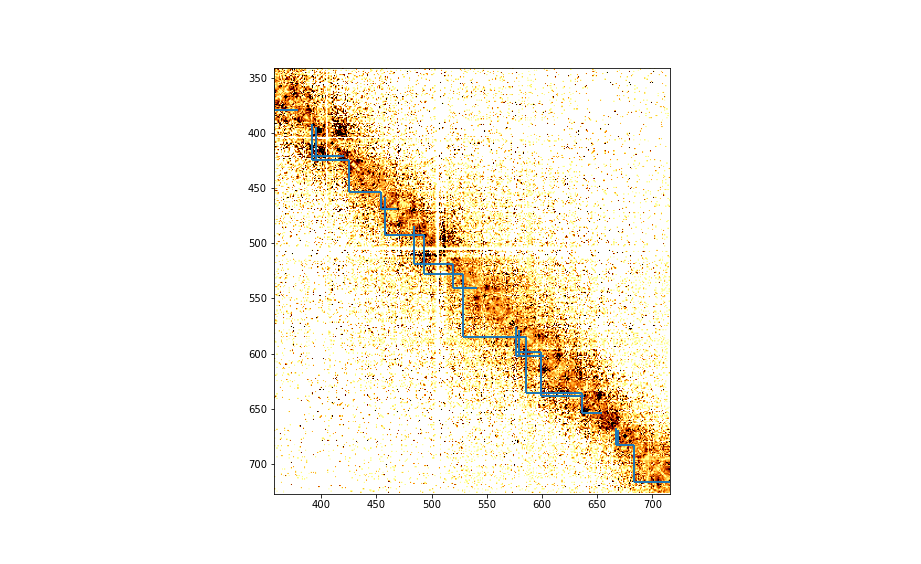

In [165]:
%matplotlib notebook
import cooler
from chromosight.utils.preprocessing import detrend
from matplotlib import collections  as mc

clr = cooler.Cooler('data/output/cool/all_merged.cool')
region = 'scaffold_6'
region_start, region_end = clr.extent(region)

sel_domains = domains.query(
    '(bin1 >= @region_start) & (bin1 < @region_end) & (bin2 >= @region_start) & (bin2 < @region_end)'
)
sel_domains.bin1 -= region_start
sel_domains.bin2 -= region_start

mat = clr.matrix(sparse=True, balance=True).fetch(region)
mat = detrend(mat).toarray()

dom_lines = []
for x, y in zip(sel_domains.bin1, sel_domains.bin2):
    # Horizontal: l_border -> corner
    dom_lines.append([(x, x), (x, y)])
    # Vertical: r_border -> corner
    dom_lines.append([(y, y), (x, y)])

fig, ax = plt.subplots()
ax.imshow(mat, cmap='afmhot_r', vmax=2)
lc = mc.LineCollection(dom_lines, linewidths=2)
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

In [163]:
# save domains to a file
domains.corner_id = domains.corner_id.astype(int)
domains.sort_values(['chrom1', 'chrom2', 'start1', 'start2']).to_csv('tmp/domains.tsv', sep='\t', index=False)